In [1]:
import pandas as pd

# Load the CSV file
file_path = r"C:\Users\starw\OneDrive\바탕 화면\btc_15m_data_2018_to_2025.csv"
btc_data = pd.read_csv(file_path)

# Convert the "Open time" column to datetime format and set it as the index
btc_data['Open time'] = pd.to_datetime(btc_data['Open time'])
btc_data.set_index('Open time', inplace=True)

# Display the first five rows of the dataframe
btc_data.head()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
Open time,,,,,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13400.01,13556.15,123.616013,2018-01-01 00:14:59.999,1.675545e+06,1572,63.227133,8.576108e+05,0
2018-01-01 00:15:00,13533.75,13550.87,13402.00,13521.12,98.136430,2018-01-01 00:29:59.999,1.321757e+06,1461,47.686389,6.422812e+05,0
2018-01-01 00:30:00,13500.00,13545.37,13450.00,13470.41,79.904037,2018-01-01 00:44:59.999,1.078825e+06,1000,43.710406,5.900347e+05,0
2018-01-01 00:45:00,13494.65,13690.87,13450.00,13529.01,141.699719,2018-01-01 00:59:59.999,1.917783e+06,1195,73.897993,1.000614e+06,0
2018-01-01 01:00:00,13528.99,13571.74,13402.28,13445.63,72.537533,2018-01-01 01:14:59.999,9.778198e+05,898,34.257652,4.618369e+05,0


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select the "Close" price column
close_prices = btc_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Function to generate sequences of length 60 for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Generate sequences
seq_length = 60
X, y = create_sequences(scaled_close_prices, seq_length)

# Split the data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (199514, 60, 1), (199514, 1)
Testing data shape: (49879, 60, 1), (49879, 1)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and a dropout layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

# Add the second LSTM layer with 50 units and a dropout layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense layer to output a single predicted value
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

c:\Users\starw\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 213s 34ms/step - loss: 4.8823e-04 - val_loss: 1.3114e-04
Epoch 2/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 238s 38ms/step - loss: 1.6810e-04 - val_loss: 0.0016
Epoch 3/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 218s 35ms/step - loss: 1.5729e-04 - val_loss: 0.0059
Epoch 4/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 274s 37ms/step - loss: 1.5268e-04 - val_loss: 0.0030
Epoch 5/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 1.5055e-04 - val_loss: 0.0059
Epoch 6/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 242s 39ms/step - loss: 1.4734e-04 - val_loss: 0.0042
Epoch 7/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 212s 31ms/step - loss: 1.4493e-04 - val_loss: 0.0048
Epoch 8/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 242s 39ms/step - loss: 1.4462e-04 - val_loss: 0.0035
Epoch 9/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 235s 38ms/step - loss: 1.4270e-04 - val_loss: 0.0059
Epoch 10/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 203s 28ms/step - loss: 1.4253e-04 - val_loss: 0.0040
Epoch 11/20
6235/6235 ━━━━━━━━━━━━━━━━━━━━ 21

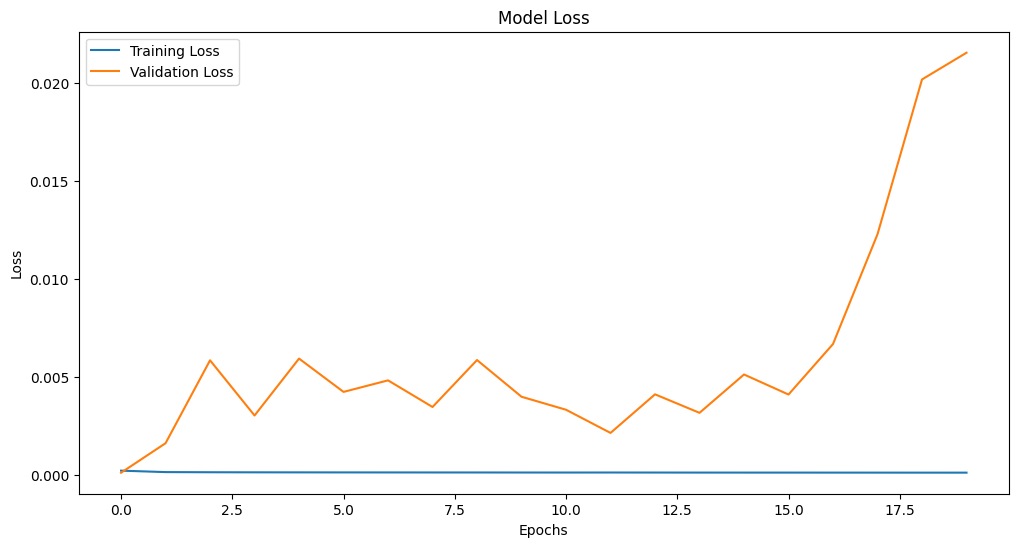

In [4]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1559/1559 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step


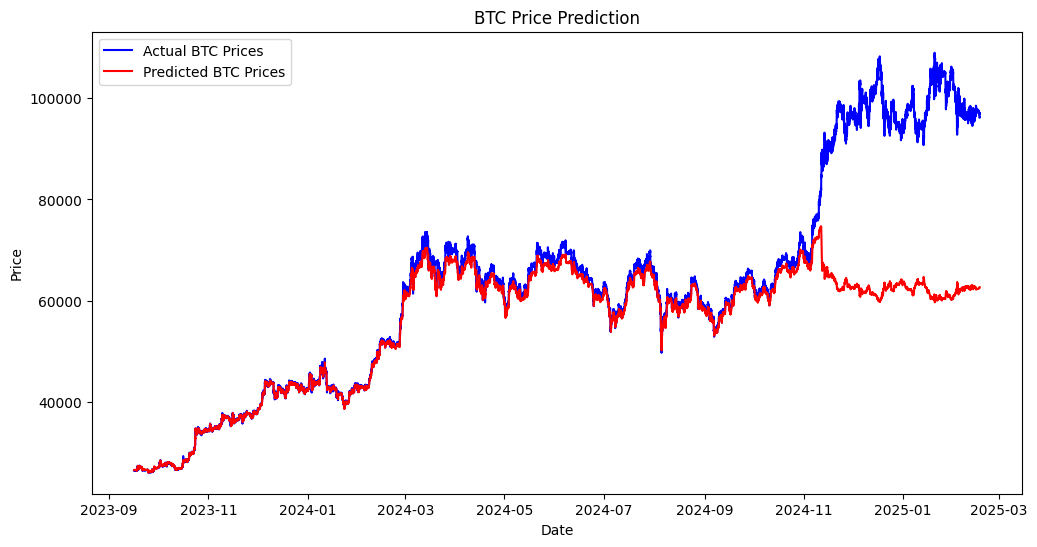

In [5]:
# Predict the BTC prices on the test dataset
predicted_prices = model.predict(X_test)

# Inverse transform the predicted prices back to the original price scale
predicted_prices = scaler.inverse_transform(predicted_prices)

# Inverse transform the actual prices back to the original price scale
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted prices vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index[-len(actual_prices):], actual_prices, color='blue', label='Actual BTC Prices')
plt.plot(btc_data.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted BTC Prices')
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\starw\AppData\Local\Temp\ipykernel_29336\3819082341.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start='2025-03-01', periods=future_steps, freq='M')


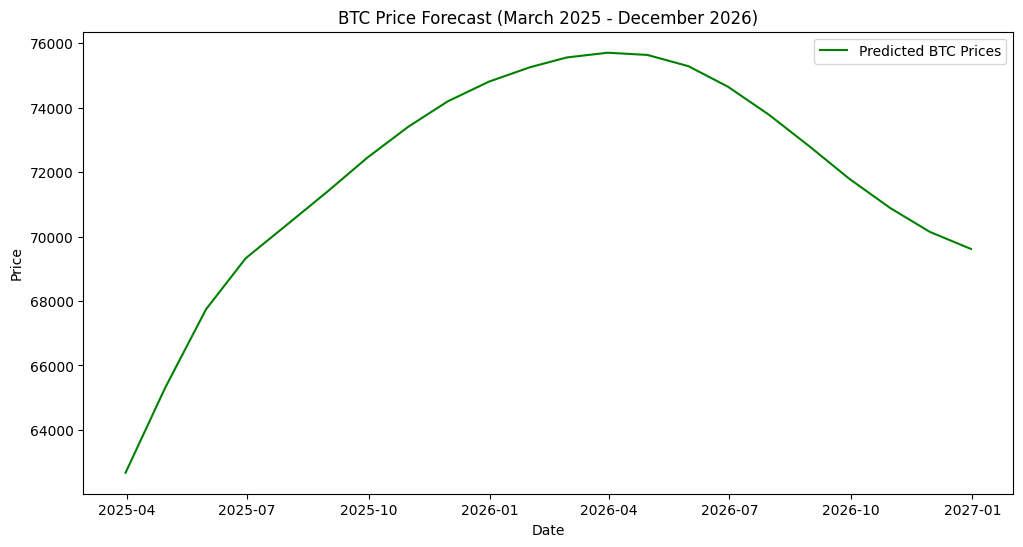

In [7]:
# Define the number of future time steps to predict
future_steps = (2026 - 2025) * 12 + 10  # From March 2025 to December 2026

# Get the last known prices from the test set
last_known_prices = X_test[-1]

# Initialize a list to store the predicted future prices
future_predictions = []

# Generate future predictions
for _ in range(future_steps):
    # Predict the next price
    next_price = model.predict(last_known_prices.reshape(1, seq_length, 1))
    
    # Append the predicted price to the future predictions list
    future_predictions.append(next_price[0, 0])
    
    # Update the last known prices by removing the first price and adding the predicted price
    last_known_prices = np.append(last_known_prices[1:], next_price).reshape(seq_length, 1)

# Inverse transform the predicted future prices back to the original price scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate the future time index
future_dates = pd.date_range(start='2025-03-01', periods=future_steps, freq='M')

# Plot the predicted BTC prices for the forecasted period
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, color='green', label='Predicted BTC Prices')
plt.title('BTC Price Forecast (March 2025 - December 2026)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Generate a DataFrame with columns ["Month", "Predicted BTC Price"]
future_predictions_df = pd.DataFrame({
    'Month': future_dates.strftime('%Y-%m'),
    'Predicted BTC Price': future_predictions.flatten()
})

# Print the full DataFrame without truncation
print(future_predictions_df)

      Month  Predicted BTC Price
0   2025-03         62672.535156
1   2025-04         65308.175781
2   2025-05         67747.289062
3   2025-06         69327.085938
4   2025-07         70359.781250
5   2025-08         71399.953125
6   2025-09         72445.101562
7   2025-10         73404.578125
8   2025-11         74194.929688
9   2025-12         74802.484375
10  2026-01         75249.539062
11  2026-02         75554.648438
12  2026-03         75701.515625
13  2026-04         75632.820312
14  2026-05         75285.265625
15  2026-06         74647.359375
16  2026-07         73779.570312
17  2026-08         72787.312500
18  2026-09         71786.906250
19  2026-10         70879.984375
20  2026-11         70140.210938
21  2026-12         69613.843750
